<a href="https://colab.research.google.com/github/prashanth-acsq/Kaggle-Notebooks/blob/main/4ac/4ac-cnextt-a384.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Setup**

In [1]:
from time import time
start_time = time()

from IPython.display import clear_output
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!mkdir ~/.data
!kaggle competitions download -c 4-animal-classification -p /.data
!unzip 4-animal-classification.zip

clear_output()

print(f"Time Taken to download data : {(time()-start_time)/60:.2f} minutes")

Time Taken to download data : 0.22 minutes


In [2]:
%cd /.data
!unzip 4-animal-classification.zip
!rm 4-animal-classification.zip
%cd ..

clear_output()

In [3]:
!pip install timm -q

     |████████████████████████████████| 509 kB 5.0 MB/s 


### **Make Dataframe**

In [4]:
import os
import pandas as pd

path: str = "/.data/train"
    
df = pd.DataFrame(data=None, columns=["filenames", "folder_names", "classes"])
folders = sorted(os.listdir(path))

filenames: list = []
folder_names: list = []
classes: list = []
i: int = 0
    
for folder_name in folders:
    for filename in os.listdir(os.path.join(path, folder_name)):
        filenames.append(filename)
        folder_names.append(folder_name)
        classes.append(i)
    i += 1

df.filenames = filenames
df.folder_names = folder_names
df.classes = classes

df.to_csv("/content/data.csv", index=False)

### **E2E Train**

In [5]:
import os
import re
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.model_selection import StratifiedKFold

In [6]:
SEED = 42
SIZE = 384


def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")


def get_image(path: str, size: int=224) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    return cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)


def show_loss_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()


def show_accuracy_graphs(A: list) -> None:
    TA, VA = [], []
    for i in range(len(A)):
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TA) + 1)
    plt.figure()
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()


def show_lr_graph(LR: list) -> None:
    x_Axis = [i+1 for i in range(len(LR))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LR, "rx")
    plt.grid()
    plt.show()

In [7]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 size: int = 224,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 ):
        self.seed = seed
        self.size = size
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.train_transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.48807, 0.46220, 0.38045], [0.21216, 0.20883, 0.20863]),
        #     transforms.RandomAffine(degrees=(-45, 45), translate=(0.15, 0.15), scale=(0.5, 1.5)),
        #     transforms.RandomHorizontalFlip(p=0.25),
        #     transforms.RandomVerticalFlip(p=0.25),
        # ])
        # self.valid_transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.48807, 0.46220, 0.38045], [0.21216, 0.20883, 0.20863]),
        # ])

        # 384
        self.train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.48805, 0.46218, 0.38043], [0.21471, 0.21141, 0.21124]),
            transforms.RandomAffine(degrees=(-45, 45), translate=(0.15, 0.15), scale=(0.5, 1.5)),
            transforms.RandomHorizontalFlip(p=0.25),
            transforms.RandomVerticalFlip(p=0.25),
        ])
        self.valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.48805, 0.46218, 0.38043], [0.21471, 0.21141, 0.21124]),
        ])
                                
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(seed=SEED, size=SIZE)

In [8]:
class TrainDS(Dataset):
    def __init__(
        self, 
        base_path: str,
        filenames: np.ndarray, 
        folder_names: np.ndarray, 
        labels: np.ndarray, 
        size: int,
        transform=None):
        
        self.base_path = base_path
        self.filenames = filenames
        self.folder_names = folder_names
        self.labels = labels
        self.size = size
        self.transform = transform
    
    def __len__(self):
        return self.filenames.shape[0]
    
    def __getitem__(self, idx):
        path = os.path.join(os.path.join(self.base_path, self.folder_names[idx]), self.filenames[idx])
        image = get_image(path, self.size)
        return self.transform(image), self.labels[idx]

In [9]:
class TestDS(Dataset):
    def __init__(
        self, 
        base_path: str,
        filenames: np.ndarray, 
        size: int,
        transform=None):
        
        self.base_path = base_path
        self.filenames = filenames
        self.size = size
        self.transform = transform
    
    def __len__(self):
        return self.filenames.shape[0]
    
    def __getitem__(self, idx):
        path = os.path.join(self.base_path, str(self.filenames[idx]) + ".jpg")
        image = get_image(path, self.size)
        return self.transform(image)

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
            
        self.model = timm.create_model(model_name="convnext_tiny_384_in22ft1k", pretrained=True)
        self.model.head.fc = nn.Linear(in_features=self.model.fc.head.in_features, out_features=4)
            
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False

    def forward(self, x):
        return nn.LogSoftmax(dim=1)(self.model(x))

In [ ]:
def fit(model=None,
        optimizer=None, 
        scheduler_rlrop=None,
        scheduler_oclr=None,
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        save_path=None,
        device=None,
        verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.argmax(y_pred, dim=1)
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss: dict = {"train" : np.inf, "valid" : np.inf} 
    bestAccs: dict = {"train" : 0.0, "valid" : 0.0}
        
    Losses: list = []
    Accuracies: list = [] 
    LRs: list = []
        
    if fold: 
        ble_name = f"ble_state_fold_{fold}.pt"
        bae_name = f"bae_state_fold_{fold}.pt"
    else: 
        ble_name = f"ble_state.pt"
        bae_name = f"bae_state.pt"
    
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss: dict = {"train" : 0.0, "valid" : 0.0} 
        epochAccs: dict = {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass: list = []
            accsPerPass: list = []
                
            for X, y in dataloaders[phase]:
                X, y = X.to(device), y.to(device).view(-1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.NLLLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        if scheduler_oclr: LRs.append(scheduler_oclr.get_last_lr())
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
    
        if scheduler_oclr:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_oclr.state_dict()}
        
        elif scheduler_rlrop:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_rlrop.state_dict()}
        
        else:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict()}
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, ble_name))
                torch.save(save_dict, os.path.join(save_path, bae_name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict,os.path.join(save_path, ble_name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
            torch.save(save_dict,os.path.join(save_path, bae_name))
        
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} |\
 Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                        epochLoss["train"], epochLoss["valid"], 
                                                                        epochAccs["train"], epochAccs["valid"], 
                                                                        time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, LRs, bestLoss, bestAccs, BLE, BAE, ble_name, bae_name


def predict_batch(model=None, dataloader=None, path=None, device=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    y_pred = torch.zeros(1, 1).to(device)
    
    for X in dataloader:
        X = X.to(device)
        with torch.no_grad():
            output = torch.argmax(torch.exp(model(X)), dim=1)
        y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

In [ ]:
df = pd.read_csv("/content/data.csv")

filenames = df.filenames.copy().values
folder_names = df.folder_names.copy().values
labels = df.classes.copy().values


**************************************************

Training Fold 1...

**************************************************

Epoch: 1 | Train Loss: 0.94695 | Valid Loss: 0.19674 | Train Accs: 0.60134 | Valid Accs: 0.94821 | Time: 60.90 seconds
Epoch: 2 | Train Loss: 0.30419 | Valid Loss: 0.16984 | Train Accs: 0.89241 | Valid Accs: 0.94821 | Time: 54.99 seconds
Epoch: 3 | Train Loss: 0.42487 | Valid Loss: 0.22212 | Train Accs: 0.85179 | Valid Accs: 0.92857 | Time: 53.44 seconds
Epoch: 4 | Train Loss: 0.51228 | Valid Loss: 0.48796 | Train Accs: 0.80804 | Valid Accs: 0.80536 | Time: 53.75 seconds
Epoch: 5 | Train Loss: 0.52305 | Valid Loss: 0.38092 | Train Accs: 0.80580 | Valid Accs: 0.85714 | Time: 53.81 seconds
Epoch: 6 | Train Loss: 0.45990 | Valid Loss: 0.33593 | Train Accs: 0.82589 | Valid Accs: 0.88571 | Time: 53.68 seconds
Epoch: 7 | Train Loss: 0.43563 | Valid Loss: 0.41084 | Train Accs: 0.83929 | Valid Accs: 0.85893 | Time: 53.30 seconds

Early Stopping at Epoch 8

**************

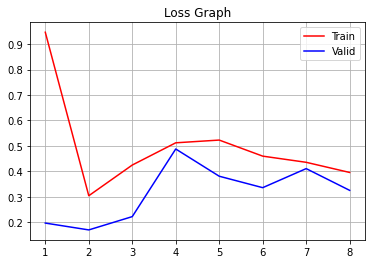


**************************************************



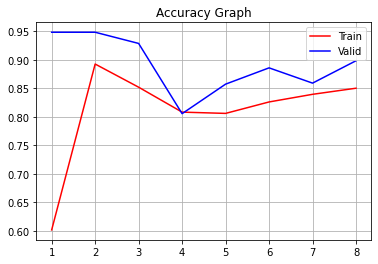


**************************************************



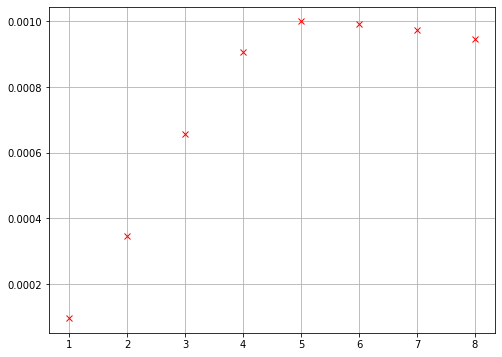


**************************************************


**************************************************

Training Fold 2...

**************************************************

Epoch: 1 | Train Loss: 0.94959 | Valid Loss: 0.16382 | Train Accs: 0.59911 | Valid Accs: 0.96786 | Time: 53.73 seconds
Epoch: 2 | Train Loss: 0.28932 | Valid Loss: 0.16252 | Train Accs: 0.89643 | Valid Accs: 0.94643 | Time: 53.69 seconds
Epoch: 3 | Train Loss: 0.46781 | Valid Loss: 0.25116 | Train Accs: 0.82723 | Valid Accs: 0.91429 | Time: 53.60 seconds
Epoch: 4 | Train Loss: 0.49326 | Valid Loss: 0.38876 | Train Accs: 0.81250 | Valid Accs: 0.85893 | Time: 53.40 seconds
Epoch: 5 | Train Loss: 0.50324 | Valid Loss: 0.37904 | Train Accs: 0.82009 | Valid Accs: 0.87321 | Time: 53.23 seconds
Epoch: 6 | Train Loss: 0.45769 | Valid Loss: 0.39407 | Train Accs: 0.82366 | Valid Accs: 0.85893 | Time: 53.01 seconds
Epoch: 7 | Train Loss: 0.44850 | Valid Loss: 0.25849 | Train Accs: 0.83437 | Valid Accs: 0.91786 | Time: 53.

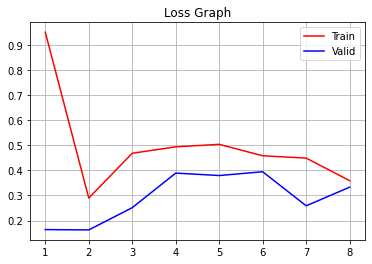


**************************************************



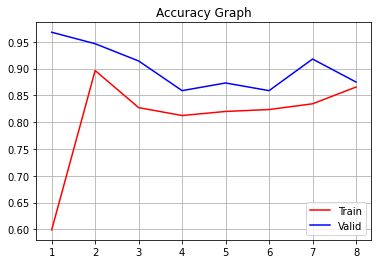


**************************************************



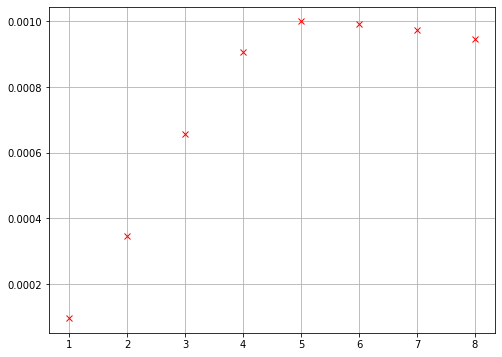


**************************************************


**************************************************

Training Fold 3...

**************************************************

Epoch: 1 | Train Loss: 0.94733 | Valid Loss: 0.16534 | Train Accs: 0.59955 | Valid Accs: 0.96071 | Time: 53.93 seconds
Epoch: 2 | Train Loss: 0.29336 | Valid Loss: 0.23260 | Train Accs: 0.89777 | Valid Accs: 0.92500 | Time: 53.84 seconds
Epoch: 3 | Train Loss: 0.42219 | Valid Loss: 0.45825 | Train Accs: 0.84777 | Valid Accs: 0.84286 | Time: 53.01 seconds
Epoch: 4 | Train Loss: 0.54494 | Valid Loss: 0.35209 | Train Accs: 0.79911 | Valid Accs: 0.87321 | Time: 53.30 seconds
Epoch: 5 | Train Loss: 0.50717 | Valid Loss: 0.35997 | Train Accs: 0.81116 | Valid Accs: 0.87321 | Time: 54.02 seconds
Epoch: 6 | Train Loss: 0.46002 | Valid Loss: 0.28969 | Train Accs: 0.83795 | Valid Accs: 0.91250 | Time: 53.41 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoc

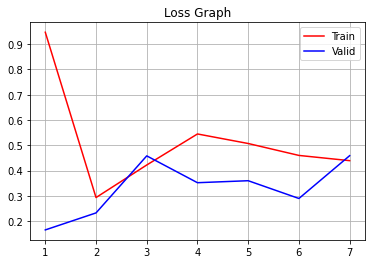


**************************************************



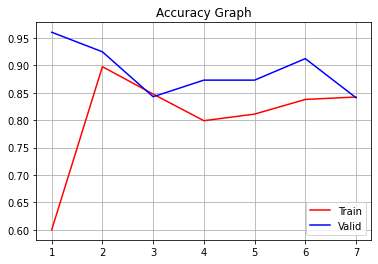


**************************************************



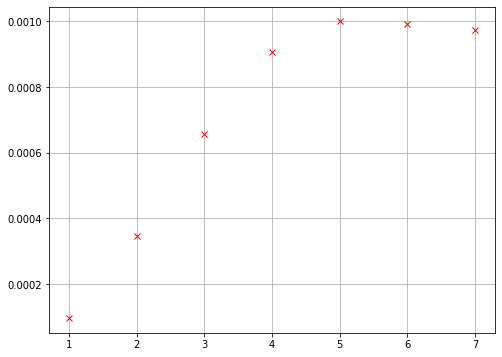


**************************************************


**************************************************

Training Fold 4...

**************************************************

Epoch: 1 | Train Loss: 0.94810 | Valid Loss: 0.15179 | Train Accs: 0.60268 | Valid Accs: 0.96250 | Time: 54.91 seconds
Epoch: 2 | Train Loss: 0.28974 | Valid Loss: 0.16039 | Train Accs: 0.90982 | Valid Accs: 0.94821 | Time: 53.48 seconds
Epoch: 3 | Train Loss: 0.43862 | Valid Loss: 0.25511 | Train Accs: 0.83795 | Valid Accs: 0.90179 | Time: 53.32 seconds
Epoch: 4 | Train Loss: 0.47752 | Valid Loss: 0.26964 | Train Accs: 0.82366 | Valid Accs: 0.90893 | Time: 53.50 seconds
Epoch: 5 | Train Loss: 0.48322 | Valid Loss: 0.37131 | Train Accs: 0.81964 | Valid Accs: 0.86607 | Time: 54.51 seconds
Epoch: 6 | Train Loss: 0.43272 | Valid Loss: 0.27045 | Train Accs: 0.84464 | Valid Accs: 0.90357 | Time: 53.44 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoc

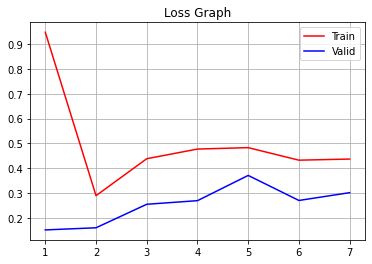


**************************************************



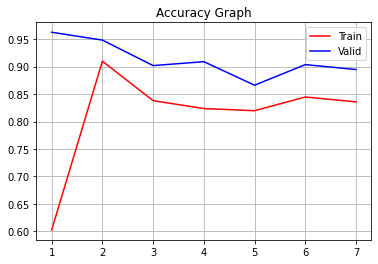


**************************************************



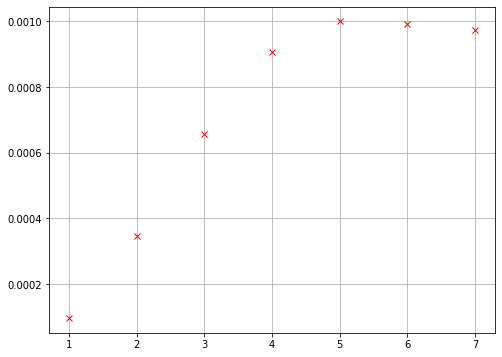


**************************************************


**************************************************

Training Fold 5...

**************************************************

Epoch: 1 | Train Loss: 0.93703 | Valid Loss: 0.16307 | Train Accs: 0.61205 | Valid Accs: 0.95714 | Time: 54.13 seconds
Epoch: 2 | Train Loss: 0.32235 | Valid Loss: 0.29272 | Train Accs: 0.88438 | Valid Accs: 0.88393 | Time: 53.40 seconds
Epoch: 3 | Train Loss: 0.41738 | Valid Loss: 0.26975 | Train Accs: 0.84509 | Valid Accs: 0.91250 | Time: 53.04 seconds
Epoch: 4 | Train Loss: 0.49706 | Valid Loss: 0.24320 | Train Accs: 0.82143 | Valid Accs: 0.90357 | Time: 54.30 seconds
Epoch: 5 | Train Loss: 0.45253 | Valid Loss: 0.27873 | Train Accs: 0.83125 | Valid Accs: 0.88750 | Time: 53.31 seconds
Epoch: 6 | Train Loss: 0.43267 | Valid Loss: 0.43794 | Train Accs: 0.84196 | Valid Accs: 0.84286 | Time: 53.43 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoc

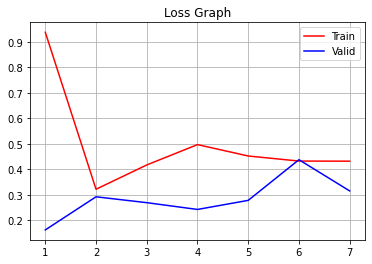


**************************************************



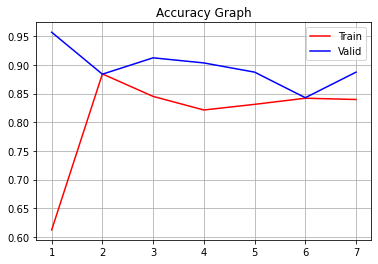


**************************************************



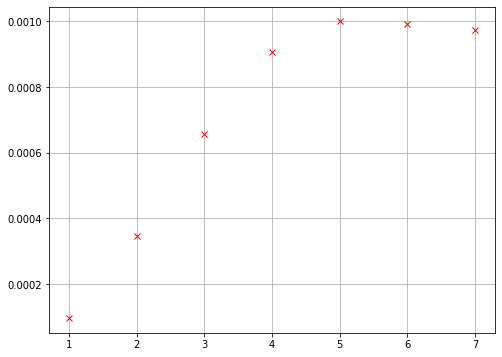


**************************************************



In [ ]:
fold: int = 1
BLs: list = []
BAs: list = []
    
for tr_idx, va_idx in StratifiedKFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(filenames, labels):

    tr_filenames, va_filenames       = filenames[tr_idx], filenames[va_idx] 
    tr_folder_names, va_folder_names = folder_names[tr_idx], folder_names[va_idx] 
    tr_labels, va_labels             = labels[tr_idx], labels[va_idx]
    
    tr_data_setup = TrainDS(
        base_path="/.data/train", 
        filenames=tr_filenames, 
        folder_names=tr_folder_names,
        labels=tr_labels.reshape(-1, 1),
        size=cfg.size,
        transform=cfg.train_transform)
    
    va_data_setup = TrainDS(
        base_path="/.data/train", 
        filenames=va_filenames, 
        folder_names=va_folder_names,
        labels=va_labels.reshape(-1, 1),
        size=cfg.size,
        transform=cfg.valid_transform)

    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
        "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
    }

    cfg = CFG(
        size=SIZE,
        epochs=25, 
        batch_size=16, 
        early_stopping=5,
        steps_per_epoch=len(dataloaders["train"])
    )
    
    torch.manual_seed(cfg.seed)
    model = Model().to(cfg.device)

    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    # optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    # optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd, momentum=0.9)
    
    scheduler_oclr = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer, 
        max_lr=cfg.max_lr, 
        epochs=cfg.epochs, 
        steps_per_epoch=cfg.steps_per_epoch,
        pct_start=cfg.pct_start, 
        div_factor=cfg.div_factor, 
        final_div_factor=cfg.final_div_factor
    )

    # scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer=optimizer,
    #     patience=cfg.patience,
    #     eps=cfg.eps,
    #     verbose=True
    # )

    # scheduler_oclr = None
    scheduler_rlrop = None
    
    L, A, LR, BL, BA, _, _, _, _ = fit(
        model=model, 
        optimizer=optimizer, 
        scheduler_oclr=scheduler_oclr,
        scheduler_rlrop=scheduler_rlrop,
        epochs=cfg.epochs, 
        early_stopping_patience=cfg.early_stopping, 
        dataloaders=dataloaders, 
        device=cfg.device,
        save_path=cfg.save_path,
        fold=fold,
        verbose=True
    )
    
    breaker()
    show_loss_graphs(L)
    breaker()
    show_accuracy_graphs(A)
    breaker()
    if scheduler_oclr:
        show_lr_graph(LR)
        breaker()
    
    BLs.append(BL)
    BAs.append(BA)
    
    fold += 1

In [ ]:
BL = np.inf
for i in range(len(BLs)):
    if BLs[i]["valid"] < BL:
        BL = BLs[i]["valid"]
        best_loss_index = i

        
BA = 0.0
for i in range(len(BAs)):
    if BAs[i]["valid"] > BA:
        BA = BAs[i]["valid"]
        best_accs_index = i


breaker()
print(f"Best Loss Model Fold     : {best_loss_index + 1}")
print(f"Best Accuracy Model Fold : {best_accs_index + 1}")
breaker()


**************************************************

Best Loss Model Fold     : 4
Best Accuracy Model Fold : 2

**************************************************



In [ ]:
unp# torch.manual_seed(cfg.seed)
# model = Model().to(cfg.device)

# ss_df = pd.read_csv("/.data/Sample_submission.csv")
# ts_filenames = ss_df["ID"]

# ts_data_setup = DS(
#     base_path="/.data/test/test", 
#     filenames=ts_filenames, 
#     size=cfg.size,
#     transform=cfg.valid_transform,
# )
# ts_data = DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False)

# y_pred = predict_batch(
#     model=model,
#     dataloader=ts_data,
#     path="",
#     device=cfg.device
# )

# ss_df["Label"] = y_pred.astype("uint8")
# ss_df.to_csv("submission.csv", index=False)